In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM


In [2]:
edge_crop = 32
patch_size = 25

num_images = 5000
num_patches = 5000

channel = 'LED119'
confidence_interval = 90
num_bootstrap_samples = 50

images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)


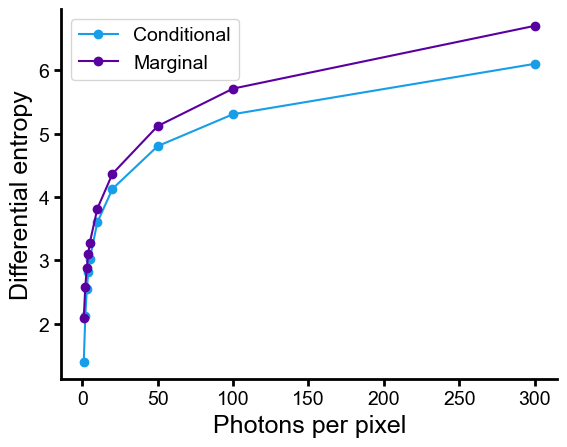

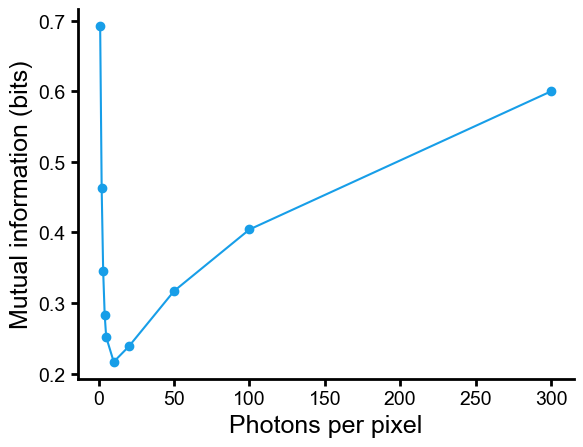

In [11]:
# photons_per_pixel_values = [0.01, 0.1, 0.5, 1, 2, 4, 10, 50]
photons_per_pixel_values = [1, 2, 3, 4, 5, 10, 20, 50, 100, 300]
# photons_per_pixel_values = [10, 20, 50 , 100, 300]

conditionals = []
marginals = []
mi = []
for photons_per_pixel in photons_per_pixel_values:
    noisy_patches = add_noise(patches * photons_per_pixel / np.mean(images), seed=123)
    noisy_patches + onp.random.normal(size=noisy_patches.shape) 
    # mi.append(estimate_mutual_information(noisy_images=noisy_patches, verbose=True))
    h_y_given_x = compute_conditional_entropy(noisy_patches) / np.log(2)
    h_y_gaussian = gaussian_entropy_estimate(noisy_patches, stationary=True, eigenvalue_floor=1, show_plot=False) / np.log(2)
    conditionals.append(h_y_given_x)
    marginals.append(h_y_gaussian)
    mi.append(h_y_gaussian - h_y_given_x)

# plot both
fig, ax = plt.subplots()
ax.plot(photons_per_pixel_values, conditionals, '-o', label='Conditional')
ax.plot(photons_per_pixel_values, marginals, '-o', label='Marginal')
ax.set_xlabel('Photons per pixel')
ax.set_ylabel('Differential entropy')
ax.legend()
clear_spines(ax)

fig, ax = plt.subplots()
ax.plot(photons_per_pixel_values, mi, '-o')
ax.set_xlabel('Photons per pixel')
ax.set_ylabel('Mutual information (bits)')
clear_spines(ax)

## Does using the non-stationary gaussian model rescue it? No

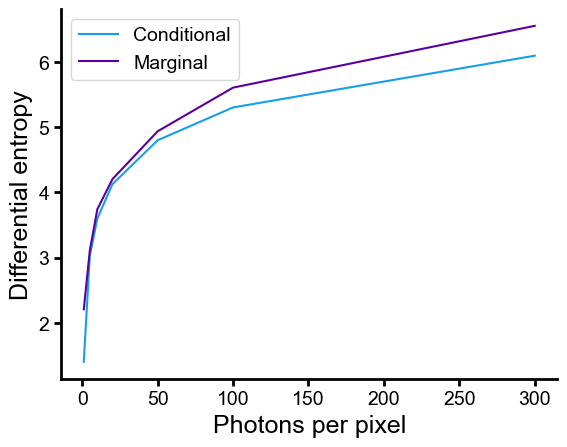

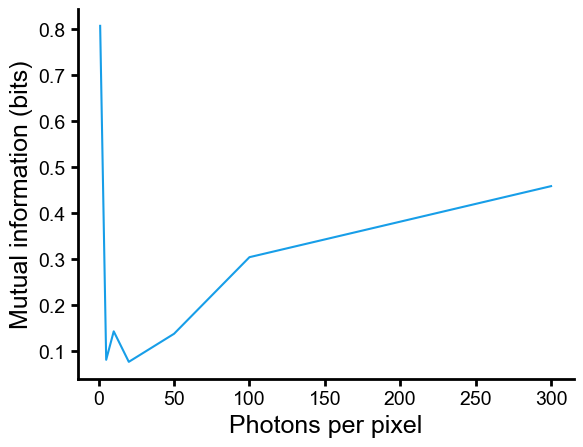

In [8]:
# photons_per_pixel_values = [0.01, 0.1, 0.5, 1, 2, 4, 10, 50]
photons_per_pixel_values = [1, 5, 10, 20, 50, 100, 300]
# photons_per_pixel_values = [10, 20, 50 , 100, 300]

conditionals = []
marginals = []
mi = []
for photons_per_pixel in photons_per_pixel_values:
    noisy_patches = add_noise(patches * photons_per_pixel / np.mean(images), seed=123)
    noisy_patches + onp.random.normal(size=noisy_patches.shape) 
    # mi.append(estimate_mutual_information(noisy_images=noisy_patches, verbose=True))
    h_y_given_x = compute_conditional_entropy(noisy_patches) / np.log(2)
    h_y_gaussian = gaussian_entropy_estimate(noisy_patches, stationary=False, eigenvalue_floor=1, show_plot=False) / np.log(2)
    conditionals.append(h_y_given_x)
    marginals.append(h_y_gaussian)
    mi.append(h_y_gaussian - h_y_given_x)

# plot both
fig, ax = plt.subplots()
ax.plot(photons_per_pixel_values, conditionals, label='Conditional')
ax.plot(photons_per_pixel_values, marginals, label='Marginal')
ax.set_xlabel('Photons per pixel')
ax.set_ylabel('Differential entropy')
ax.legend()
clear_spines(ax)

fig, ax = plt.subplots()
ax.plot(photons_per_pixel_values, mi)
ax.set_xlabel('Photons per pixel')
ax.set_ylabel('Mutual information (bits)')
clear_spines(ax)

## Does generating the conditional entropy estimate from samples from the gaussian fit rescue it?
run the first two notebooks cells to prep for this

In [9]:
from information_estimation import *

# photons_per_pixel_values = [0.01, 0.1, 0.5, 1, 2, 4, 10, 50]
photons_per_pixel_values = [1, 2, 3, 4, 5, 10, 20, 50, 100, 300]
# photons_per_pixel_values = [10, 20, 50 , 100, 300]


mi = []
for photons_per_pixel in photons_per_pixel_values:
    noisy_patches = add_noise(patches * photons_per_pixel / np.mean(images), seed=123)
    noisy_patches + onp.random.normal(size=noisy_patches.shape) 
    lower_photon_clean_images = patches * photons_per_pixel / np.mean(images)
    mi.append(estimate_mutual_information(noisy_images=noisy_patches, eigenvalue_floor=1e-12,
                                          clean_images=lower_photon_clean_images, estimate_conditional_from_model_samples=True,
                                verbose=True))


fig, ax = plt.subplots()
ax.plot(photons_per_pixel_values, mi, '-o')
ax.set_xlabel('Photons per pixel')
ax.set_ylabel('Mutual information (bits)')
clear_spines(ax)
fig.suptitle('MI with conditional entropy estimated from model samples')

/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:238: UserWarning: Mean pixel value is 0.97. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")
100%|██████████| 49/49 [00:01<00:00, 32.94it/s]


Estimated H(Y|X) = 1.818 bits/pixel
Estimated H(Y) = 2.057 bits/pixel
Estimated I(Y;X) = 0.239 bits/pixel


/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:238: UserWarning: Mean pixel value is 1.94. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")
100%|██████████| 49/49 [00:01<00:00, 34.32it/s]


Estimated H(Y|X) = 2.388 bits/pixel
Estimated H(Y) = 2.576 bits/pixel
Estimated I(Y;X) = 0.188 bits/pixel


/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:238: UserWarning: Mean pixel value is 2.92. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")
100%|██████████| 49/49 [00:01<00:00, 34.30it/s]


Estimated H(Y|X) = 2.714 bits/pixel
Estimated H(Y) = 2.883 bits/pixel
Estimated I(Y;X) = 0.169 bits/pixel


/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:238: UserWarning: Mean pixel value is 3.89. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")
100%|██████████| 49/49 [00:01<00:00, 32.92it/s]


Estimated H(Y|X) = 2.938 bits/pixel
Estimated H(Y) = 3.103 bits/pixel
Estimated I(Y;X) = 0.165 bits/pixel


/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:238: UserWarning: Mean pixel value is 4.86. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")
100%|██████████| 49/49 [00:01<00:00, 33.82it/s]


Estimated H(Y|X) = 3.110 bits/pixel
Estimated H(Y) = 3.275 bits/pixel
Estimated I(Y;X) = 0.164 bits/pixel


/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:238: UserWarning: Mean pixel value is 9.72. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")
100%|██████████| 49/49 [00:01<00:00, 33.76it/s]


Estimated H(Y|X) = 3.638 bits/pixel
Estimated H(Y) = 3.815 bits/pixel
Estimated I(Y;X) = 0.177 bits/pixel


/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:238: UserWarning: Mean pixel value is 19.45. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")
100%|██████████| 49/49 [00:01<00:00, 33.33it/s]


Estimated H(Y|X) = 4.146 bits/pixel
Estimated H(Y) = 4.365 bits/pixel
Estimated I(Y;X) = 0.219 bits/pixel


100%|██████████| 49/49 [00:01<00:00, 34.39it/s]


Estimated H(Y|X) = 4.805 bits/pixel
Estimated H(Y) = 5.118 bits/pixel
Estimated I(Y;X) = 0.313 bits/pixel


100%|██████████| 49/49 [00:01<00:00, 34.92it/s]


Estimated H(Y|X) = 5.304 bits/pixel
Estimated H(Y) = 5.711 bits/pixel
Estimated I(Y;X) = 0.407 bits/pixel


100%|██████████| 49/49 [00:01<00:00, 33.67it/s]


ValueError: Covariance matrix is not positive definite

## Does adding iterative estimation help?

In [14]:

# photons_per_pixel_values = [0.01, 0.1, 0.5, 1, 2, 4, 10, 50]
photons_per_pixel_values = [1, 2, 3, 4, 5, 10, 20, 50, 100, 300]
# photons_per_pixel_values = [10, 20, 50 , 100, 300]


mi = []
for photons_per_pixel in photons_per_pixel_values:
    noisy_patches = add_noise(patches * photons_per_pixel / np.mean(images), seed=123)
    noisy_patches + onp.random.normal(size=noisy_patches.shape) 
    lower_photon_clean_images = patches * photons_per_pixel / np.mean(images)
    mi.append(estimate_mutual_information(noisy_images=noisy_patches, eigenvalue_floor=1e-3, use_iterative_optimization=True,
                                          clean_images=lower_photon_clean_images, estimate_conditional_from_model_samples=True,
                                        #   learning_rate=1e-10, 
                                        #   batch_size=40,
                                verbose=True))


fig, ax = plt.subplots()
ax.plot(photons_per_pixel_values, mi, '-o')
ax.set_xlabel('Photons per pixel')
ax.set_ylabel('Mutual information (bits)')
clear_spines(ax)
fig.suptitle('MI with conditional entropy estimated from model samples')

/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:250: UserWarning: Mean pixel value is 0.97. Mutual information estimates may be inaccurate at low photon counts.
  if np.mean(clean_images_if_available) < 20:


Initial loss:  -1085.1637990993588


/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process_utils.py:530: UserWarning: Optimization did not improve the validation loss, returning initial covariance matrix
  


Final loss:  2191.031958829215
Initial loss:  888.4507333966383
Final loss:  1058.1566836591683 2578.8245595926837
Estimated H(Y|X) = 1.818 bits/pixel
Estimated H(Y) = 2.058 bits/pixel
Estimated I(Y;X) = 0.240 bits/pixel


/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:250: UserWarning: Mean pixel value is 1.95. Mutual information estimates may be inaccurate at low photon counts.
  if np.mean(clean_images_if_available) < 20:


Initial loss:  -674.0683079346746
Final loss:  2256.436435263373: 2582.3916807828746
Initial loss:  1113.70195456955
Final loss:  2035.7737417553546 2391.5240205305163
Estimated H(Y|X) = 2.386 bits/pixel
Estimated H(Y) = 2.577 bits/pixel
Estimated I(Y;X) = 0.190 bits/pixel


/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:250: UserWarning: Mean pixel value is 2.92. Mutual information estimates may be inaccurate at low photon counts.
  if np.mean(clean_images_if_available) < 20:


Initial loss:  -390.357919224509


KeyboardInterrupt: 